# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-06 21:56:06.373965: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 21:56:06.400840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 21:56:06.400864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 21:56:06.401436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 21:56:06.405868: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


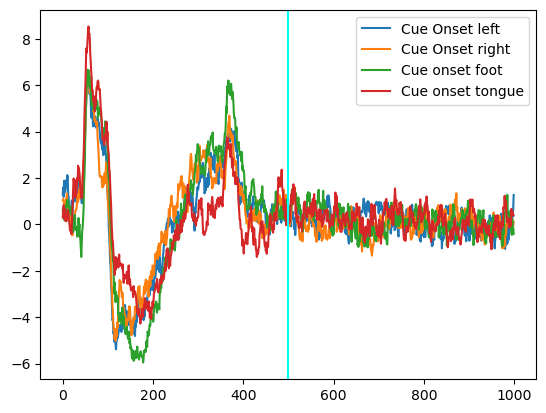

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:

def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# CNN Model Architecture

In [5]:
from EEG_CNN import CNN
from EEG_ResNet import ResNetCustom

In [6]:
import itertools
from keras.utils import plot_model
# Building the CNN model using sequential class
reg = {'reg 1e-2': 1e-2, 'reg 1e-3': 1e-3, 'reg 1e-4': 1e-4}
filters = {'3x1 filter': 3, '5x1 filter': 5, '7x1 filter' : 7}
convdepth = {'5 convlayers': 5, '6 convlayers': 6, '7 convlayers': 7}
hyperparams = [reg, filters, convdepth]

# resnet = ResNetCustom()
# resnet.summary()
models_names = []
# models = [ResNetCustom(reg=0.01, pool_size=3, dropout=0.5, first_conv_num=25, first_conv_size=5,
#                        res_filter_sizes=[5 for _ in range(10)],
#                        res_num_filters=[min(200, 25 * (2 ** i)) for i in range(10)])]
models = []

for a in itertools.product(*[hyperparam.items() for hyperparam in hyperparams]):
    models_names.append([i[0] for i in a])
    models.append(ResNetCustom(reg = a[0][1], res_filter_sizes=[a[1][1] for _ in range(a[2][1])],
                               res_num_filters=[min(200, 25 * (2 ** i)) for i in range(a[2][1])]))
# plot_model(models[0], to_file='../Gallery/ResNetCustom.png', show_shapes=True, show_layer_names=True)
# for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
#     models_names.append([i[0] for i in a])
#     models.append(CNN(input_shape=(400,1,22), use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
#                       filters=[a[3][1] for _ in range(a[4][1])],
#                       num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


2024-03-06 21:56:09.634796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 21:56:09.672383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 21:56:09.672589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Train CNN Model

In [7]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 5e-4

epochs = 200
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for model in models:
# Training and validating the model
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=8, min_lr=3e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=256,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)
    )



Epoch 1/200


2024-03-06 21:56:20.601534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-06 21:56:20.977544: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-06 21:56:22.244483: I external/local_xla/xla/service/service.cc:168] XLA service 0x71f931a11f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 21:56:22.244506: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-06 21:56:22.248334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709790982.326079  118863 device_compiler.h:186] Compiled cluster us

30/30 [==============================] - 11s 99ms/step - loss: 16.9664 - accuracy: 0.2578 - val_loss: 15.7204 - val_accuracy: 0.3000 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 24ms/step - loss: 15.8302 - accuracy: 0.2646 - val_loss: 14.8251 - val_accuracy: 0.2960 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 14.8396 - accuracy: 0.2580 - val_loss: 13.9417 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 24ms/step - loss: 13.8671 - accuracy: 0.2602 - val_loss: 13.0922 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 20ms/step - loss: 12.9923 - accuracy: 0.2605 - val_loss: 12.2549 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 23ms/step - loss: 12.1381 - accuracy: 0.2635 - val_loss: 11.4483 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 7/200
30/30 [==========================

2024-03-06 21:58:31.664543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 36ms/step - loss: 22.3779 - accuracy: 0.2531 - val_loss: 20.4681 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 20.2673 - accuracy: 0.2531 - val_loss: 18.8474 - val_accuracy: 0.2640 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 19ms/step - loss: 18.7283 - accuracy: 0.2477 - val_loss: 17.6232 - val_accuracy: 0.2160 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 19ms/step - loss: 17.5324 - accuracy: 0.2448 - val_loss: 16.5772 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 20ms/step - loss: 16.4384 - accuracy: 0.2584 - val_loss: 15.6232 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 22ms/step - loss: 15.4686 - accuracy: 0.2584 - val_loss: 14.7289 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:00:43.795848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 38ms/step - loss: 27.6137 - accuracy: 0.2511 - val_loss: 25.0832 - val_accuracy: 0.1760 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 24.4150 - accuracy: 0.2532 - val_loss: 22.7016 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 22ms/step - loss: 22.2826 - accuracy: 0.2580 - val_loss: 21.0345 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 20ms/step - loss: 20.7261 - accuracy: 0.2491 - val_loss: 19.7290 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 19.4453 - accuracy: 0.2583 - val_loss: 18.6079 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 18.3595 - accuracy: 0.2457 - val_loss: 17.5828 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:03:13.985417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 9s 94ms/step - loss: 16.5939 - accuracy: 0.2491 - val_loss: 15.2828 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 15.0116 - accuracy: 0.2584 - val_loss: 13.8569 - val_accuracy: 0.3200 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 22ms/step - loss: 13.8877 - accuracy: 0.2672 - val_loss: 12.9978 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 21ms/step - loss: 13.0037 - accuracy: 0.2551 - val_loss: 12.2483 - val_accuracy: 0.2480 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 22ms/step - loss: 12.1461 - accuracy: 0.2670 - val_loss: 11.4937 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 24ms/step - loss: 11.3718 - accuracy: 0.2606 - val_loss: 10.7739 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:05:37.188169: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 36ms/step - loss: 21.6120 - accuracy: 0.2465 - val_loss: 19.3480 - val_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 19ms/step - loss: 18.6085 - accuracy: 0.2540 - val_loss: 17.1156 - val_accuracy: 0.2720 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 16.9081 - accuracy: 0.2536 - val_loss: 15.8848 - val_accuracy: 0.2960 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 19ms/step - loss: 15.7648 - accuracy: 0.2571 - val_loss: 14.9540 - val_accuracy: 0.2640 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 20ms/step - loss: 14.8307 - accuracy: 0.2422 - val_loss: 14.1148 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 13.9579 - accuracy: 0.2521 - val_loss: 13.3165 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:07:50.492254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 33ms/step - loss: 26.5904 - accuracy: 0.2495 - val_loss: 23.1739 - val_accuracy: 0.2360 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 21ms/step - loss: 22.2948 - accuracy: 0.2483 - val_loss: 20.3631 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 20.0589 - accuracy: 0.2531 - val_loss: 18.8540 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 18.7236 - accuracy: 0.2487 - val_loss: 17.8700 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 17.7163 - accuracy: 0.2633 - val_loss: 17.0057 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 22ms/step - loss: 16.8756 - accuracy: 0.2539 - val_loss: 16.2259 - val_accuracy: 0.2720 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:10:20.244325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-06 22:10:24.706808: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-06 22:10:24.739223: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


30/30 [==============================] - 10s 93ms/step - loss: 16.4347 - accuracy: 0.2461 - val_loss: 14.7252 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 14.5946 - accuracy: 0.2523 - val_loss: 13.4188 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 23ms/step - loss: 13.4682 - accuracy: 0.2619 - val_loss: 12.5971 - val_accuracy: 0.3320 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 24ms/step - loss: 12.6227 - accuracy: 0.2680 - val_loss: 11.8959 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 11.8759 - accuracy: 0.2625 - val_loss: 11.2036 - val_accuracy: 0.3000 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 25ms/step - loss: 11.1371 - accuracy: 0.2665 - val_loss: 10.5387 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 7/200
30/30 [==========================

2024-03-06 22:12:38.209070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 37ms/step - loss: 21.0706 - accuracy: 0.2528 - val_loss: 18.1845 - val_accuracy: 0.2840 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 17.6360 - accuracy: 0.2599 - val_loss: 16.1303 - val_accuracy: 0.3040 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 21ms/step - loss: 16.0414 - accuracy: 0.2536 - val_loss: 15.0767 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 15.0052 - accuracy: 0.2586 - val_loss: 14.2761 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 23ms/step - loss: 14.1748 - accuracy: 0.2473 - val_loss: 13.5084 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 21ms/step - loss: 13.4000 - accuracy: 0.2554 - val_loss: 12.7717 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:14:57.520148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_55/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 32ms/step - loss: 25.8877 - accuracy: 0.2513 - val_loss: 22.0262 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 23ms/step - loss: 20.9449 - accuracy: 0.2528 - val_loss: 19.0317 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 18.7616 - accuracy: 0.2528 - val_loss: 17.6830 - val_accuracy: 0.2960 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 17.5917 - accuracy: 0.2508 - val_loss: 16.7841 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 27ms/step - loss: 16.7007 - accuracy: 0.2516 - val_loss: 15.9804 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 23ms/step - loss: 15.8679 - accuracy: 0.2595 - val_loss: 15.1889 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 7/200
30/30 [===========================

2024-03-06 22:17:26.206901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_63/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 29ms/step - loss: 3.7135 - accuracy: 0.2539 - val_loss: 3.1322 - val_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 19ms/step - loss: 3.4976 - accuracy: 0.2583 - val_loss: 2.9730 - val_accuracy: 0.1920 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 19ms/step - loss: 3.3904 - accuracy: 0.2544 - val_loss: 2.9037 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 3.2745 - accuracy: 0.2657 - val_loss: 2.8917 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 19ms/step - loss: 3.2242 - accuracy: 0.2513 - val_loss: 2.8818 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 18ms/step - loss: 3.1491 - accuracy: 0.2496 - val_loss: 2.8517 - val_accuracy: 0.2960 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 24

2024-03-06 22:19:40.829395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_69/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 31ms/step - loss: 4.2537 - accuracy: 0.2512 - val_loss: 4.8561 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 26ms/step - loss: 3.8998 - accuracy: 0.2594 - val_loss: 3.4588 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 21ms/step - loss: 3.7591 - accuracy: 0.2536 - val_loss: 3.2384 - val_accuracy: 0.3160 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 23ms/step - loss: 3.6330 - accuracy: 0.2529 - val_loss: 3.2237 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 3.5742 - accuracy: 0.2489 - val_loss: 3.2060 - val_accuracy: 0.2720 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 21ms/step - loss: 3.4769 - accuracy: 0.2694 - val_loss: 3.1914 - val_accuracy: 0.2520 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 20

2024-03-06 22:22:00.387674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 35ms/step - loss: 4.8076 - accuracy: 0.2547 - val_loss: 3.9397 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 23ms/step - loss: 4.3542 - accuracy: 0.2643 - val_loss: 3.6888 - val_accuracy: 0.3160 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 22ms/step - loss: 4.1417 - accuracy: 0.2598 - val_loss: 3.6171 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 4.0000 - accuracy: 0.2576 - val_loss: 3.5833 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 25ms/step - loss: 3.9005 - accuracy: 0.2527 - val_loss: 3.5588 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 24ms/step - loss: 3.8407 - accuracy: 0.2535 - val_loss: 3.5407 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 21

2024-03-06 22:24:31.500318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 28ms/step - loss: 3.6213 - accuracy: 0.2504 - val_loss: 2.9901 - val_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 3.3641 - accuracy: 0.2562 - val_loss: 2.8863 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 3.2162 - accuracy: 0.2542 - val_loss: 2.7376 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 20ms/step - loss: 3.1018 - accuracy: 0.2544 - val_loss: 2.7260 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 22ms/step - loss: 3.0347 - accuracy: 0.2591 - val_loss: 2.7419 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 2.9924 - accuracy: 0.2607 - val_loss: 2.7288 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 19

2024-03-06 22:26:53.623734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 33ms/step - loss: 4.0981 - accuracy: 0.2543 - val_loss: 3.2894 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 23ms/step - loss: 3.7235 - accuracy: 0.2501 - val_loss: 3.0883 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 22ms/step - loss: 3.5079 - accuracy: 0.2462 - val_loss: 3.0417 - val_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 27ms/step - loss: 3.3841 - accuracy: 0.2606 - val_loss: 3.0221 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 3.3133 - accuracy: 0.2664 - val_loss: 3.0125 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 21ms/step - loss: 3.2424 - accuracy: 0.2595 - val_loss: 2.9927 - val_accuracy: 0.2720 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 24

2024-03-06 22:29:23.641972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_97/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 38ms/step - loss: 4.6412 - accuracy: 0.2515 - val_loss: 3.6918 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 25ms/step - loss: 4.0783 - accuracy: 0.2643 - val_loss: 3.4170 - val_accuracy: 0.2640 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 3.8491 - accuracy: 0.2493 - val_loss: 3.3321 - val_accuracy: 0.3040 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 26ms/step - loss: 3.6989 - accuracy: 0.2475 - val_loss: 3.3047 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 25ms/step - loss: 3.6174 - accuracy: 0.2532 - val_loss: 3.2884 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 24ms/step - loss: 3.5555 - accuracy: 0.2592 - val_loss: 3.2775 - val_accuracy: 0.2520 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 24

2024-03-06 22:31:57.015063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_105/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 34ms/step - loss: 3.6233 - accuracy: 0.2511 - val_loss: 3.2502 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 3.2814 - accuracy: 0.2626 - val_loss: 2.9135 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 26ms/step - loss: 3.1389 - accuracy: 0.2491 - val_loss: 2.6957 - val_accuracy: 0.2000 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 21ms/step - loss: 3.0268 - accuracy: 0.2574 - val_loss: 2.6691 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 2.9425 - accuracy: 0.2651 - val_loss: 2.6668 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 19ms/step - loss: 2.9180 - accuracy: 0.2531 - val_loss: 2.6378 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 18

2024-03-06 22:34:15.224934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_111/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 29ms/step - loss: 4.1073 - accuracy: 0.2509 - val_loss: 3.2398 - val_accuracy: 0.2080 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 3.6133 - accuracy: 0.2583 - val_loss: 3.0032 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 25ms/step - loss: 3.4038 - accuracy: 0.2511 - val_loss: 2.9302 - val_accuracy: 0.3120 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 23ms/step - loss: 3.2913 - accuracy: 0.2601 - val_loss: 2.9324 - val_accuracy: 0.2080 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 3.2111 - accuracy: 0.2629 - val_loss: 2.9333 - val_accuracy: 0.2080 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 23ms/step - loss: 3.1717 - accuracy: 0.2582 - val_loss: 2.9072 - val_accuracy: 0.2520 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 23

2024-03-06 22:36:43.968696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_17/dropout_118/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 39ms/step - loss: 4.5357 - accuracy: 0.2503 - val_loss: 3.5829 - val_accuracy: 0.2520 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 24ms/step - loss: 3.8946 - accuracy: 0.2517 - val_loss: 3.2750 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 26ms/step - loss: 3.6518 - accuracy: 0.2575 - val_loss: 3.2066 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 28ms/step - loss: 3.5250 - accuracy: 0.2492 - val_loss: 3.1858 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 3.4578 - accuracy: 0.2566 - val_loss: 3.1737 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 27ms/step - loss: 3.4009 - accuracy: 0.2528 - val_loss: 3.1621 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 23

2024-03-06 22:39:24.087374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_126/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 28ms/step - loss: 2.3336 - accuracy: 0.2548 - val_loss: 2.0249 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 21ms/step - loss: 2.1167 - accuracy: 0.2633 - val_loss: 1.5997 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 2.0248 - accuracy: 0.2489 - val_loss: 1.5546 - val_accuracy: 0.2680 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 20ms/step - loss: 1.9308 - accuracy: 0.2570 - val_loss: 1.5716 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 19ms/step - loss: 1.8607 - accuracy: 0.2544 - val_loss: 1.5884 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 19ms/step - loss: 1.8336 - accuracy: 0.2505 - val_loss: 1.5826 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 22

2024-03-06 22:41:45.990853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_132/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 33ms/step - loss: 2.4455 - accuracy: 0.2500 - val_loss: 1.8881 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 21ms/step - loss: 2.2175 - accuracy: 0.2626 - val_loss: 1.5963 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 23ms/step - loss: 2.1058 - accuracy: 0.2571 - val_loss: 1.5960 - val_accuracy: 0.2200 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 23ms/step - loss: 2.0099 - accuracy: 0.2493 - val_loss: 1.6057 - val_accuracy: 0.2120 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 1.9441 - accuracy: 0.2505 - val_loss: 1.5992 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 25ms/step - loss: 1.8963 - accuracy: 0.2484 - val_loss: 1.6024 - val_accuracy: 0.2560 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 26

2024-03-06 22:44:14.301181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_139/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 36ms/step - loss: 2.4232 - accuracy: 0.2516 - val_loss: 1.6501 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 26ms/step - loss: 2.2263 - accuracy: 0.2476 - val_loss: 1.6167 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 2.0846 - accuracy: 0.2422 - val_loss: 1.6098 - val_accuracy: 0.2840 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 26ms/step - loss: 1.9851 - accuracy: 0.2583 - val_loss: 1.6045 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 1.9509 - accuracy: 0.2499 - val_loss: 1.6044 - val_accuracy: 0.2640 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 26ms/step - loss: 1.8791 - accuracy: 0.2524 - val_loss: 1.6075 - val_accuracy: 0.2840 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 26

2024-03-06 22:46:47.674195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_147/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 30ms/step - loss: 2.3170 - accuracy: 0.2563 - val_loss: 1.8309 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 24ms/step - loss: 2.0908 - accuracy: 0.2579 - val_loss: 1.5452 - val_accuracy: 0.2920 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 21ms/step - loss: 1.9564 - accuracy: 0.2602 - val_loss: 1.5143 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 24ms/step - loss: 1.9245 - accuracy: 0.2519 - val_loss: 1.5303 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 21ms/step - loss: 1.8241 - accuracy: 0.2680 - val_loss: 1.5344 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 24ms/step - loss: 1.8042 - accuracy: 0.2564 - val_loss: 1.5313 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 25

2024-03-06 22:49:10.613902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_153/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 31ms/step - loss: 2.3880 - accuracy: 0.2579 - val_loss: 1.7488 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 24ms/step - loss: 2.1709 - accuracy: 0.2566 - val_loss: 1.5706 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 21ms/step - loss: 2.0241 - accuracy: 0.2592 - val_loss: 1.5506 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 25ms/step - loss: 1.9341 - accuracy: 0.2590 - val_loss: 1.5513 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 28ms/step - loss: 1.9141 - accuracy: 0.2509 - val_loss: 1.5472 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 23ms/step - loss: 1.8474 - accuracy: 0.2591 - val_loss: 1.5602 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 22

2024-03-06 22:51:37.290958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_160/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 32ms/step - loss: 2.4301 - accuracy: 0.2517 - val_loss: 1.7391 - val_accuracy: 0.2080 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 2.2059 - accuracy: 0.2446 - val_loss: 1.5906 - val_accuracy: 0.2960 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 28ms/step - loss: 2.0639 - accuracy: 0.2500 - val_loss: 1.5849 - val_accuracy: 0.2760 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 26ms/step - loss: 1.9662 - accuracy: 0.2460 - val_loss: 1.5817 - val_accuracy: 0.2360 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 1.8970 - accuracy: 0.2610 - val_loss: 1.5821 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 26ms/step - loss: 1.8475 - accuracy: 0.2520 - val_loss: 1.5829 - val_accuracy: 0.2360 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 24

2024-03-06 22:54:13.620573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_168/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 6s 29ms/step - loss: 2.2736 - accuracy: 0.2543 - val_loss: 2.3893 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 23ms/step - loss: 2.0370 - accuracy: 0.2500 - val_loss: 1.7149 - val_accuracy: 0.2480 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 1.9309 - accuracy: 0.2559 - val_loss: 1.5356 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 23ms/step - loss: 1.8451 - accuracy: 0.2610 - val_loss: 1.5091 - val_accuracy: 0.2720 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 23ms/step - loss: 1.7957 - accuracy: 0.2614 - val_loss: 1.5218 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 1.7685 - accuracy: 0.2647 - val_loss: 1.5321 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 25

2024-03-06 22:56:36.502767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_25/dropout_174/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 34ms/step - loss: 2.3629 - accuracy: 0.2554 - val_loss: 1.7906 - val_accuracy: 0.2880 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 23ms/step - loss: 2.1385 - accuracy: 0.2505 - val_loss: 1.5541 - val_accuracy: 0.2560 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 23ms/step - loss: 2.0298 - accuracy: 0.2590 - val_loss: 1.5464 - val_accuracy: 0.2840 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 22ms/step - loss: 1.9109 - accuracy: 0.2614 - val_loss: 1.5505 - val_accuracy: 0.2240 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 24ms/step - loss: 1.8749 - accuracy: 0.2615 - val_loss: 1.5505 - val_accuracy: 0.2320 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 28ms/step - loss: 1.8144 - accuracy: 0.2635 - val_loss: 1.5612 - val_accuracy: 0.2280 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 23

2024-03-06 22:59:10.410121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_26/dropout_181/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 35ms/step - loss: 2.4615 - accuracy: 0.2477 - val_loss: 1.6760 - val_accuracy: 0.2440 - lr: 5.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 26ms/step - loss: 2.1631 - accuracy: 0.2544 - val_loss: 1.5822 - val_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 26ms/step - loss: 2.0316 - accuracy: 0.2555 - val_loss: 1.5775 - val_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 23ms/step - loss: 1.9470 - accuracy: 0.2567 - val_loss: 1.5696 - val_accuracy: 0.2640 - lr: 5.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 25ms/step - loss: 1.8689 - accuracy: 0.2528 - val_loss: 1.5807 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 23ms/step - loss: 1.8480 - accuracy: 0.2528 - val_loss: 1.5732 - val_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 24

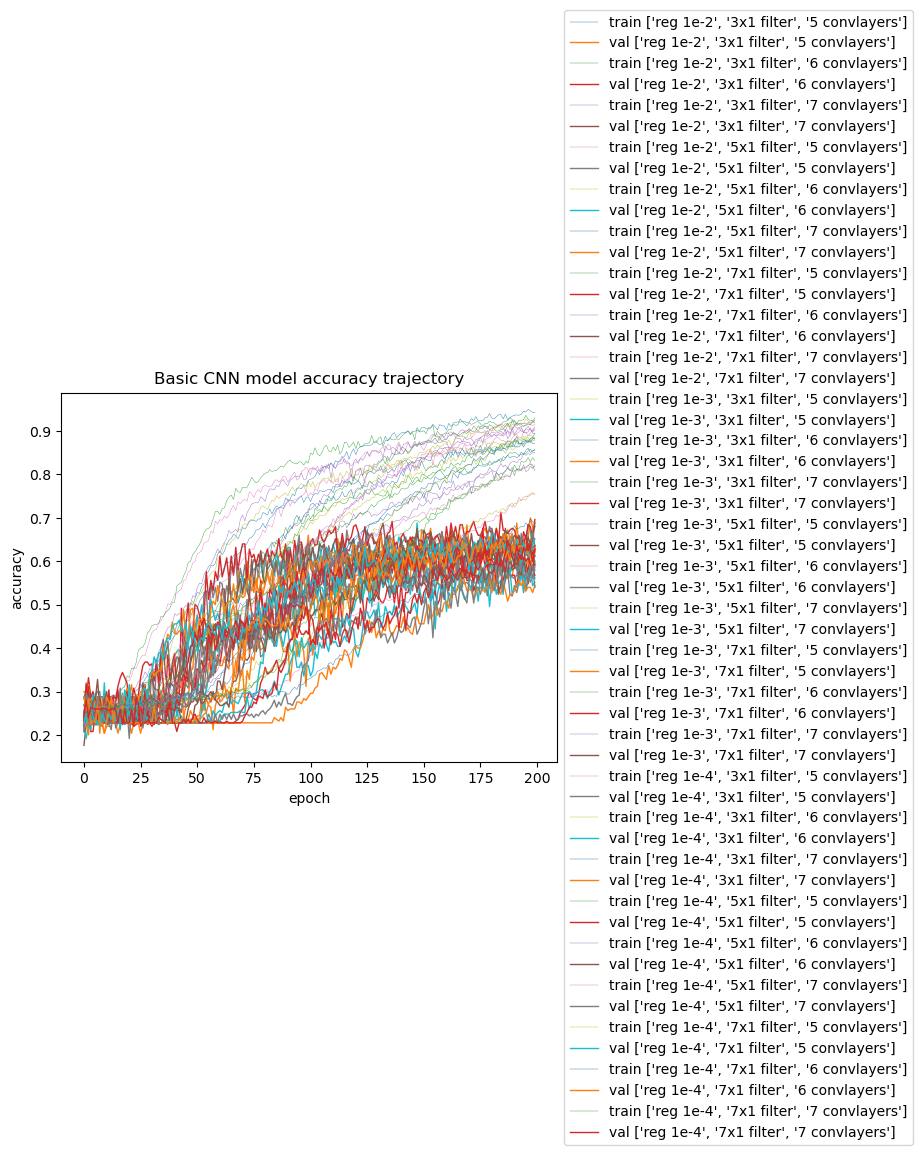

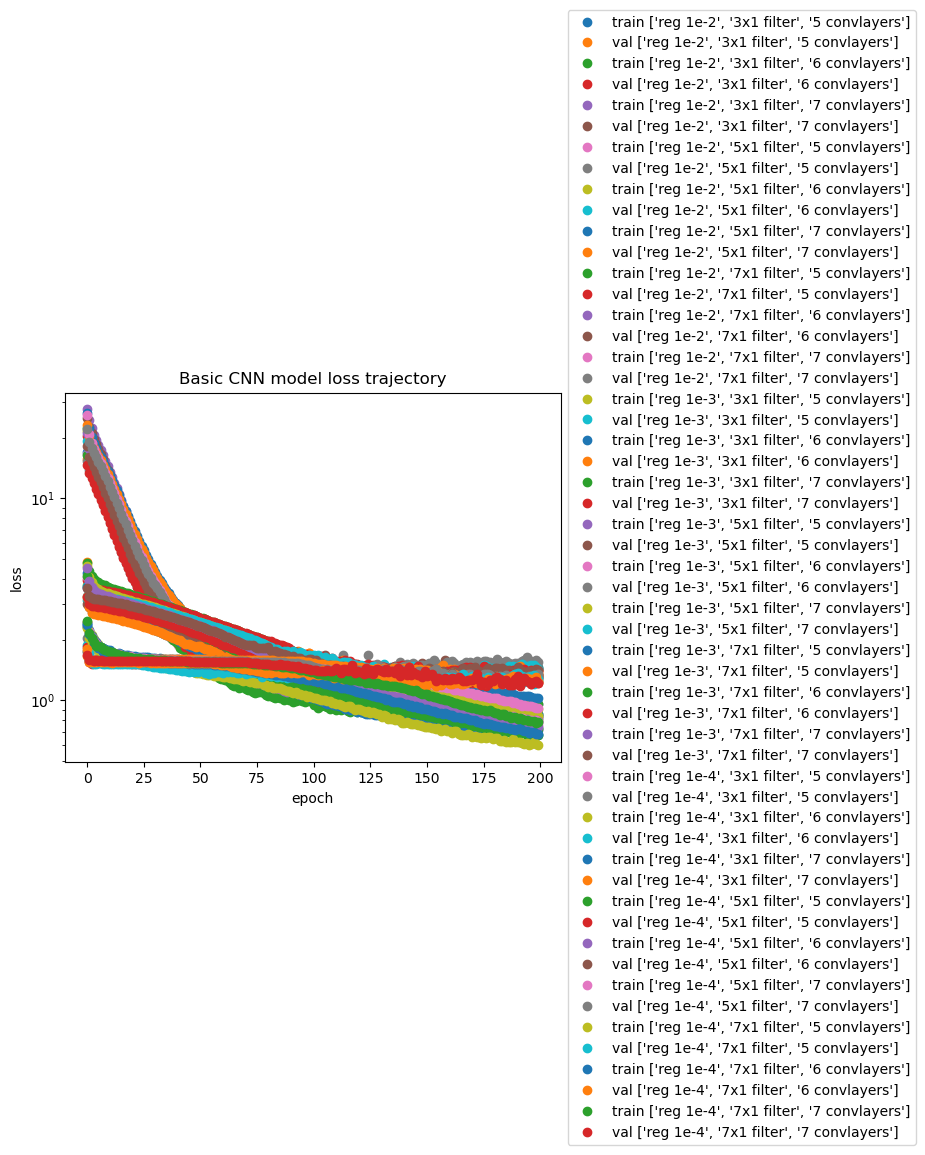

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
## Testing the basic CNN model

for model_, name in zip(models, models_names):
    cnn_score = model_.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy of {name}:',cnn_score[1])


Test accuracy of ['reg 1e-2', '3x1 filter', '5 convlayers']: 0.6185101866722107
Test accuracy of ['reg 1e-2', '3x1 filter', '6 convlayers']: 0.6410835385322571
Test accuracy of ['reg 1e-2', '3x1 filter', '7 convlayers']: 0.6749435663223267
Test accuracy of ['reg 1e-2', '5x1 filter', '5 convlayers']: 0.6749435663223267
Test accuracy of ['reg 1e-2', '5x1 filter', '6 convlayers']: 0.6568848490715027
Test accuracy of ['reg 1e-2', '5x1 filter', '7 convlayers']: 0.6591421961784363
Test accuracy of ['reg 1e-2', '7x1 filter', '5 convlayers']: 0.6817155480384827
Test accuracy of ['reg 1e-2', '7x1 filter', '6 convlayers']: 0.6839728951454163
Test accuracy of ['reg 1e-2', '7x1 filter', '7 convlayers']: 0.7020316123962402
Test accuracy of ['reg 1e-3', '3x1 filter', '5 convlayers']: 0.5327313542366028
Test accuracy of ['reg 1e-3', '3x1 filter', '6 convlayers']: 0.5801354646682739
Test accuracy of ['reg 1e-3', '3x1 filter', '7 convlayers']: 0.5282167196273804
Test accuracy of ['reg 1e-3', '5x1 filte

In [11]:
from keras.models import save_model
from keras.utils import plot_model

# Save entire model
# model_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save(model_filename)

# Save weights only
# weights_filename = f'../Models/Custom_Resnet{cnn_score[1]}.h5'
# model.save_weights(weights_filename)
# Load weights into a new model with the same architecture
# loaded_model = create_resnet_lstm_model() # create using resnet-15 architecture
# loaded_model.load_weights(weights_filename)

In [18]:
maxes_ = []
finals_ = []
for hist, name in zip(histories, models_names):
    maxes_.append(max(hist.history['val_accuracy']))
    finals_.append(hist.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(hist.history['val_accuracy'])}, final: {hist.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['reg 1e-2', '3x1 filter', '5 convlayers']: max: 0.6639999747276306, final: 0.5960000157356262
Validation accuracy ['reg 1e-2', '3x1 filter', '6 convlayers']: max: 0.671999990940094, final: 0.628000020980835
Validation accuracy ['reg 1e-2', '3x1 filter', '7 convlayers']: max: 0.671999990940094, final: 0.5920000076293945
Validation accuracy ['reg 1e-2', '5x1 filter', '5 convlayers']: max: 0.6800000071525574, final: 0.6800000071525574
Validation accuracy ['reg 1e-2', '5x1 filter', '6 convlayers']: max: 0.6880000233650208, final: 0.6119999885559082
Validation accuracy ['reg 1e-2', '5x1 filter', '7 convlayers']: max: 0.699999988079071, final: 0.6320000290870667
Validation accuracy ['reg 1e-2', '7x1 filter', '5 convlayers']: max: 0.7120000123977661, final: 0.6959999799728394
Validation accuracy ['reg 1e-2', '7x1 filter', '6 convlayers']: max: 0.6880000233650208, final: 0.6880000233650208
Validation accuracy ['reg 1e-2', '7x1 filter', '7 convlayers']: max: 0.6800000071525

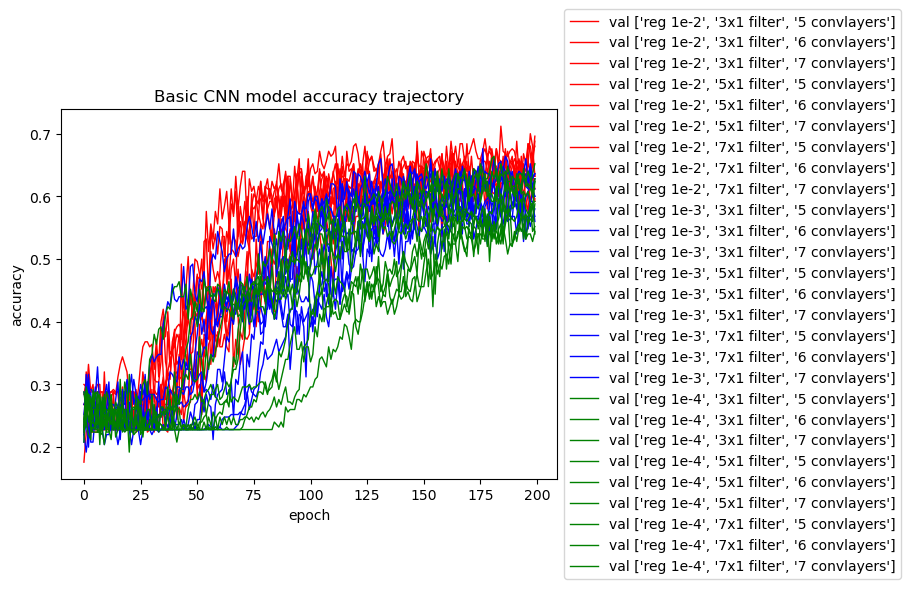

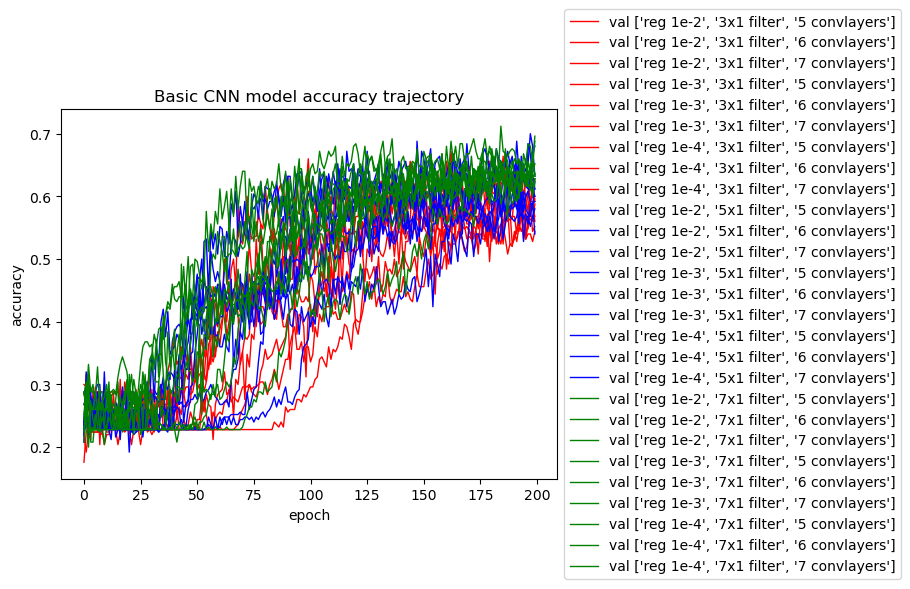

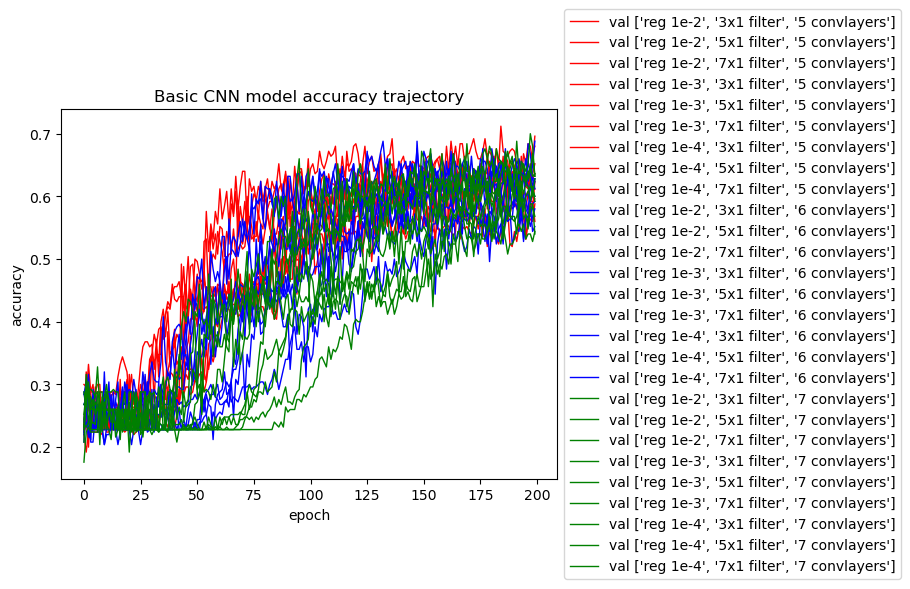

In [14]:
color = ['r', 'b', 'g']
for param in [h.items() for h in hyperparams]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()